In [1]:
from six.moves import cPickle as pickle, urllib, xrange
from __future__ import print_function
from skimage import io, color, transform
from scipy import misc
import numpy as np
import datetime
import scipy.io
import tarfile
import zipfile
import os, sys
import glob

In [2]:
ini_path = '/home/dhruv/projects_home/image_colorization/'

In [3]:
class BatchDataset:
    files = []
    images = []
    original_images = []
    image_options = {}
    batch_offset = 0
    epochs_completed = 0
    
    def __init__(self, records_list, image_options={}):
        print("Initializing Batch Dataset Reader...")
        print(image_options)
        self.files = records_list
        self.image_options = image_options
        self._read_images()

    def _read_images(self):
        self.original_images = np.array([self.read_original(filename) for filename in self.files])
        self.images = np.array([self._transform(filename) for filename in self.files])
        print (self.images.shape)
        
    def read_original(self, filename):
        try:
            image = io.imread(filename)
            if len(image.shape) < 3:  # make sure images are of shape(h,w,3)
                image = np.array([image for i in range(3)])
            
            if self.image_options.get("resize", False) and self.image_options["resize"]:
                resize_size = int(self.image_options["resize_size"])
                resize_image = misc.imresize(image,
                                             [resize_size, resize_size])
            else:
                resize_image = image
        except:
            print ("Error reading file: %s of shape %s" % (filename, str(image.shape)))
            raise
            
        return np.array(resize_image)

    def _transform(self, filename):
        try:
            image = io.imread(filename)
            if len(image.shape) < 3:  # make sure images are of shape(h,w,3)
                image = np.array([image for i in range(3)])

            if self.image_options.get("resize", False) and self.image_options["resize"]:
                resize_size = int(self.image_options["resize_size"])
                resize_image = misc.imresize(image,
                                             [resize_size, resize_size])
            else:
                resize_image = image

            if self.image_options.get("color", False):
                option = self.image_options['color']
                if option == "LAB":
                    resize_image = color.rgb2lab(resize_image)
                elif option == "HSV":
                    resize_image = color.rgb2hsv(resize_image)
        except:
            print ("Error reading file: %s of shape %s" % (filename, str(image.shape)))
            raise

        return np.array(resize_image)

    def get_records(self):
        return self.images

    def reset_batch_offset(self, offset=0):
        self.batch_offset = offset

    def next_batch(self, batch_size):
        start = self.batch_offset
        self.batch_offset += batch_size
        if self.batch_offset > self.images.shape[0]:
            # Finished epoch
            self.epochs_completed += 1
            print("****************** Epochs completed: " + str(self.epochs_completed) + "******************")
            # Shuffle the data
            perm = np.arange(self.images.shape[0])
            np.random.shuffle(perm)
            # Start next epoch
            start = 0
            self.batch_offset = batch_size

        end = self.batch_offset
        images = self.images[start:end]
        return np.expand_dims(images[:, :, :, 0], axis=3), images

    def get_random_batch(self, batch_size):
        indexes = np.random.randint(0, self.images.shape[0], size=[batch_size]).tolist()
        images = self.images[indexes]
        return np.expand_dims(images[:, :, :, 0], axis=3), images

In [4]:
def maybe_download_and_extract(dir_path, url_name, is_tarfile=True, is_zipfile=False):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    filename = url_name.split('/')[-1]
    filepath = os.path.join(dir_path, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write(
                '\r>> Downloading DATASET %s %.1f%%' % (filename, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath=ini_path + 'abc.tar'
        print("in maybe_download_and_extract")
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
        if is_tarfile:
            tarfile.open(filepath, 'r:').extractall(dir_path)
        elif is_zipfile:
            with zipfile.ZipFile(filepath) as zf:
                zip_dir = zf.namelist()[0]
                zf.extractall(dir_path)

In [5]:
def save_image(image, save_dir, name):
    image = color.lab2rgb(image)
    io.imsave(os.path.join(save_dir, name + ".png"), image)

In [6]:
def process_image(image, mean_pixel):
    return image - mean_pixel

def unprocess_image(image, mean_pixel):
    return image + mean_pixel

In [7]:
print("Reading image dataset...")
IMAGE_SIZE = 224
file_list=[]
file_glob = os.path.join(ini_path + 'lamem', "images", '*.' + 'jpg')
file_list.extend(glob.glob(file_glob))
train_images=file_list

image_options = {"resize": True, "resize_size": IMAGE_SIZE, "color": "LAB"}
batch_reader = BatchDataset(train_images, image_options)

Reading image dataset...
Initializing Batch Dataset Reader...
{'resize': True, 'resize_size': 224, 'color': 'LAB'}


/home/dhruv/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
/home/dhruv/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel/__main__.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


(108, 224, 224, 3)


## Original Images and Transformed(LAB) Images

In [8]:
images_transformed = batch_reader.get_records()
images_original = batch_reader.original_images

In [9]:
images_original.shape

(108, 224, 224, 3)

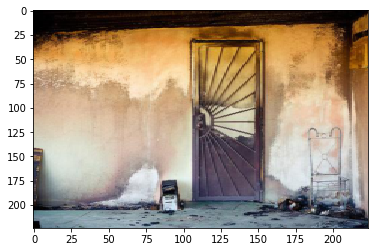

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


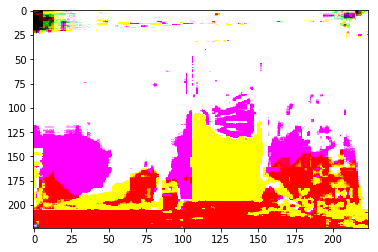

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images_original[0], aspect='auto')
plt.show()
plt.imshow(images_transformed[0], aspect='auto')
plt.show()

## Training the model

In [11]:
import tensorflow as tf
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_integer("batch_size", "16", "batch size for training")
tf.flags.DEFINE_string("logs_dir", ini_path + "logs/", "path to logs directory")
tf.flags.DEFINE_string("data_dir", ini_path, "path to dataset")
tf.flags.DEFINE_float("learning_rate", "1e-4", "Learning rate for Adam Optimizer")
tf.flags.DEFINE_float("beta1", "0.9", "Beta 1 value to use in Adam Optimizer")
tf.flags.DEFINE_string("model_dir", ini_path, "Path to vgg model mat")
tf.flags.DEFINE_bool('debug', "False", "Debug mode: True/ False")
tf.flags.DEFINE_string('mode', "train", "Mode train/ test")
MODEL_URL = ini_path + 'imagenet-vgg-verydeep-19.mat'
pickle_filepath = ini_path + 'error.pickle'

In [12]:
tf.app.flags.DEFINE_string('f', '', 'kernel')

In [13]:
def get_model_data(dir_path, model_url):
    maybe_download_and_extract(dir_path, model_url)
    filename = model_url.split("/")[-1]
    filepath = os.path.join(dir_path, filename)
    if not os.path.exists(filepath):
        raise IOError("VGG Model not found!")
    data = scipy.io.loadmat(ini_path + 'imagenet-vgg-verydeep-19.mat')
    return data

def get_variable(weights, name):
    init = tf.constant_initializer(weights, dtype=tf.float32)
    var = tf.get_variable(name=name, initializer=init, shape=weights.shape)
    return var

def weight_variable(shape, stddev=0.02, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)

def bias_variable(shape, name=None):
    initial = tf.constant(0.0, shape=shape)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)

def get_tensor_size(tensor):
    from operator import mul
    return reduce(mul, (d.value for d in tensor.get_shape()), 1)

def conv2d_basic(x, W, bias):
    conv = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")
    return tf.nn.bias_add(conv, bias)

def conv2d_strided(x, W, b):
    conv = tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding="SAME")
    return tf.nn.bias_add(conv, b)

def conv2d_transpose_strided(x, W, b, output_shape=None, stride=2):
    # print x.get_shape()
    # print W.get_shape()
    if output_shape is None:
        output_shape = x.get_shape().as_list()
        output_shape[1] *= 2
        output_shape[2] *= 2
        output_shape[3] = W.get_shape().as_list()[2]
    # print output_shape
    conv = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding="SAME")
    return tf.nn.bias_add(conv, b)

def leaky_relu(x, alpha=0.2, name=""):
    return tf.maximum(alpha * x, x, name)

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

def process_image(image, mean_pixel):
    return image - mean_pixel

def unprocess_image(image, mean_pixel):
    return image + mean_pixel

def add_to_regularization_and_summary(var):
    if var is not None:
        tf.summary.histogram(var.op.name, var)
        tf.add_to_collection("reg_loss", tf.nn.l2_loss(var))

def add_activation_summary(var):
    tf.summary.histogram(var.op.name + "/activation", var)
    tf.scalar_summary(var.op.name + "/sparsity", tf.nn.zero_fraction(var))

def add_gradient_summary(grad, var):
    if grad is not None:
        tf.summary.histogram(var.op.name + "/gradient", grad)


In [27]:
MAX_ITERATION = int(21)
ADVERSARIAL_LOSS_WEIGHT = 1e-3

def vgg_net(weights, image):
    layers = (
        # 'conv1_1', 'relu1_1',
        'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    net = {}
    current = image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i + 2][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            kernels = get_variable(np.transpose(kernels, (1, 0, 2, 3)), name=name + "_w")
            bias = get_variable(bias.reshape(-1), name=name + "_b")
            current = conv2d_basic(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current, name=name)
            if FLAGS.debug:
                add_activation_summary(current)
        elif kind == 'pool':
            current = avg_pool_2x2(current)
        net[name] = current
    print("in vgg net")
    return net

In [15]:
def generator(images, train_phase):
    print("setting up vgg initialized conv layers ...")
    model_data = get_model_data(FLAGS.model_dir, MODEL_URL)

    weights = np.squeeze(model_data['layers'])

    with tf.variable_scope("generator") as scope:
        W0 = weight_variable([3, 3, 1, 64], name="W0")
        b0 = bias_variable([64], name="b0")
        conv0 = conv2d_basic(images, W0, b0)
        hrelu0 = tf.nn.relu(conv0, name="relu")

        image_net = vgg_net(weights, hrelu0)
        vgg_final_layer = image_net["relu5_3"]

        pool5 = max_pool_2x2(vgg_final_layer)

        # now to upscale to actual image size
        deconv_shape1 = image_net["pool4"].get_shape()
        W_t1 = weight_variable([4, 4, deconv_shape1[3].value, pool5.get_shape()[3].value], name="W_t1")
        b_t1 = bias_variable([deconv_shape1[3].value], name="b_t1")
        conv_t1 = conv2d_transpose_strided(pool5, W_t1, b_t1, output_shape=tf.shape(image_net["pool4"]))
        fuse_1 = tf.add(conv_t1, image_net["pool4"], name="fuse_1")

        deconv_shape2 = image_net["pool3"].get_shape()
        W_t2 = weight_variable([4, 4, deconv_shape2[3].value, deconv_shape1[3].value], name="W_t2")
        b_t2 = bias_variable([deconv_shape2[3].value], name="b_t2")
        conv_t2 = conv2d_transpose_strided(fuse_1, W_t2, b_t2, output_shape=tf.shape(image_net["pool3"]))
        fuse_2 = tf.add(conv_t2, image_net["pool3"], name="fuse_2")

        shape = tf.shape(images)
        deconv_shape3 = tf.stack([shape[0], shape[1], shape[2], 2])
        W_t3 = weight_variable([16, 16, 2, deconv_shape2[3].value], name="W_t3")
        b_t3 = bias_variable([2], name="b_t3")
        pred = conv2d_transpose_strided(fuse_2, W_t3, b_t3, output_shape=deconv_shape3, stride=8)

    return tf.concat(axis=3, values=[images, pred], name="pred_image")

In [16]:
def train(loss, var_list):
    optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate, beta1=FLAGS.beta1)
    grads = optimizer.compute_gradients(loss, var_list=var_list)
    for grad, var in grads:
        add_gradient_summary(grad, var)
    return optimizer.apply_gradients(grads)

In [17]:
argv=None
MSE=[]
ITR=[]
ERROR={}
print("Setting up network...")
train_phase = tf.placeholder(tf.bool, name="train_phase")
images = tf.placeholder(tf.float32, shape=[None, None, None, 1], name='L_image')
lab_images = tf.placeholder(tf.float32, shape=[None, None, None, 3], name="LAB_image")

pred_image = generator(images, train_phase)

gen_loss_mse = tf.reduce_mean(2 * tf.nn.l2_loss(pred_image - lab_images)) / (IMAGE_SIZE * IMAGE_SIZE * 100 * 100)
tf.summary.scalar("Generator_loss_MSE", gen_loss_mse)

train_variables = tf.trainable_variables()
for v in train_variables:
    add_to_regularization_and_summary(var=v)

train_op = train(gen_loss_mse, train_variables)

Setting up network...
setting up vgg initialized conv layers ...
in vgg net


In [23]:
print("Setting up session")
sess = tf.Session()
summary_op = tf.summary.merge_all()
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter(FLAGS.logs_dir, sess.graph)
sess.run(tf.initialize_all_variables())

Setting up session
Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [18]:
ckpt = tf.train.get_checkpoint_state(FLAGS.logs_dir)
if ckpt and ckpt.model_checkpoint_path:
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Model restored...")

In [28]:
if FLAGS.mode == 'train':
    for itr in xrange(MAX_ITERATION):
        l_image, color_images = batch_reader.next_batch(FLAGS.batch_size)
        feed_dict = {images: l_image, lab_images: color_images, train_phase: True}

        if itr % 10 == 0:
            mse, summary_str = sess.run([gen_loss_mse, summary_op], feed_dict=feed_dict)
            summary_writer.add_summary(summary_str, itr)
            MSE.append(mse)
            ITR.append(itr//10)
            print("Step: %d, MSE: %g" % (itr, mse))

        if itr % 100 == 0:
            saver.save(sess, FLAGS.logs_dir + "model.ckpt", itr)
            pred = sess.run(pred_image, feed_dict=feed_dict)
            idx = np.random.randint(0, FLAGS.batch_size)
            save_dir = os.path.join(FLAGS.logs_dir, "image_checkpoints")
            print("shape of color images ", len(color_images))
            save_image(color_images[idx], save_dir, "gt" + str(itr//100))
            save_image(pred[idx].astype(np.float64), save_dir, "pred" + str(itr//100))
            print("%s --> Model saved" % datetime.datetime.now())

        sess.run(train_op, feed_dict=feed_dict)

        if itr % 10000 == 0:
            FLAGS.learning_rate /= 2
    ERROR["mse"]=MSE
    ERROR["itr"]=ITR
    #with open(pickle_filepath, 'wb') as f:
        #pickle.dump(ERROR, f, pickle.HIGHEST_PROTOCOL)
elif FLAGS.mode == "test":
    count = 10
    l_image, color_images = batch_reader.get_random_batch(count)
    feed_dict = {images: l_image, lab_images: color_images, train_phase: False}
    save_dir = os.path.join(FLAGS.logs_dir, "image_pred")
    pred = sess.run(pred_image, feed_dict=feed_dict)
    for itr in range(count):
        save_image(color_images[itr], save_dir, "gt" + str(itr))
        save_image(pred[itr].astype(np.float64), save_dir, "pred" + str(itr))
    print("--- Images saved on test run ---")

Step: 0, MSE: 0.958914
shape of color images  16
2018-10-13 01:10:00.925557 --> Model saved


/home/dhruv/anaconda3/envs/tensorflow/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


****************** Epochs completed: 6******************
Step: 10, MSE: 1.44319
****************** Epochs completed: 7******************
****************** Epochs completed: 8******************
Step: 20, MSE: 0.875349
